In [730]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew,boxcox
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate,KFold,cross_val_score,cross_val_predict
from sklearn.svm import SVC
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import plot_confusion_matrix,classification_report,confusion_matrix

# Załadownie danych

In [676]:
X_train = pd.read_csv('./train.csv',sep=';')
y_train = X_train['Bought_Product']
X_test = pd.read_csv('./test.csv',sep=';')
X_test_id = X_test.Id

## Podstawowe przekstałcenia

In [677]:
X_train.Sex = X_train.Sex.map({'M':0,'F':1})
X_test.Sex = X_test.Sex.map({'M':0,'F':1})
X_train.drop(['Id'],inplace=True,axis=1)
X_test.drop(['Id'],inplace=True,axis=1)

# Podstawowe informacje

Przyjrzyjmy się podstawowym statystykom zbioru treningowego oraz testowego

In [678]:
X_train.head()

,Bought_Product,Market_Segment,Online_Account,EnergyTariff,Sex,Age,Non_Energy_Product,How_many_other_contracts,Billing_Amount,District
0,0,3,0.0,G12,0,22.0,0,0,9.0000,DistrictA
1,0,2,0.0,C12,0,29.0,1,0,27.7208,DistrictA
2,0,3,0.0,G12,0,18.0,0,0,7.7958,DistrictD
3,0,3,1.0,G12,0,40.5,0,0,7.7500,DistrictD
4,0,3,1.0,G12,0,22.0,0,0,8.0500,DistrictA


In [679]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Bought_Product            626 non-null    int64  
 1   Market_Segment            626 non-null    int64  
 2   Online_Account            367 non-null    float64
 3   EnergyTariff              611 non-null    object 
 4   Sex                       626 non-null    int64  
 5   Age                       616 non-null    float64
 6   Non_Energy_Product        626 non-null    int64  
 7   How_many_other_contracts  626 non-null    int64  
 8   Billing_Amount            618 non-null    float64
 9   District                  607 non-null    object 
dtypes: float64(3), int64(5), object(2)
memory usage: 49.0+ KB


In [680]:
X_train.describe()

,Bought_Product,Market_Segment,Online_Account,Sex,Age,Non_Energy_Product,How_many_other_contracts,Billing_Amount
count,626.000000,626.000000,367.000000,626.000000,616.000000,626.000000,626.000000,618.000000
mean,0.383387,2.313099,0.493188,0.351438,29.783003,0.496805,0.364217,32.987291
std,0.486600,0.822321,0.500636,0.477801,14.943791,1.007566,0.782773,52.234536
min,0.000000,1.000000,0.000000,0.000000,0.670000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,21.000000,0.000000,0.000000,7.903100
50%,0.000000,3.000000,0.000000,0.000000,28.000000,0.000000,0.000000,14.254150
75%,1.000000,3.000000,1.000000,1.000000,38.000000,1.000000,0.000000,30.923950
max,1.000000,3.000000,1.000000,1.000000,112.000000,8.000000,5.000000,512.329200


In [681]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Market_Segment            261 non-null    int64  
 1   Online_Account            157 non-null    float64
 2   EnergyTariff              255 non-null    object 
 3   Sex                       261 non-null    int64  
 4   Age                       257 non-null    float64
 5   Non_Energy_Product        261 non-null    int64  
 6   How_many_other_contracts  261 non-null    int64  
 7   Billing_Amount            261 non-null    float64
 8   District                  246 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 18.5+ KB


In [682]:
X_test.describe()

,Market_Segment,Online_Account,Sex,Age,Non_Energy_Product,How_many_other_contracts,Billing_Amount
count,261.000000,157.000000,261.000000,257.000000,261.000000,261.000000,261.000000
mean,2.287356,0.439490,0.360153,29.680311,0.593870,0.429119,30.470421
std,0.871445,0.497913,0.480967,15.490308,1.308185,0.863665,44.339654
min,1.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,7.900000
50%,3.000000,0.000000,0.000000,28.000000,0.000000,0.000000,15.000000
75%,3.000000,1.000000,1.000000,39.000000,1.000000,1.000000,31.390000
max,3.000000,1.000000,1.000000,114.000000,8.000000,6.000000,512.330000


Widać iż zarówno dane treningowe jak i testowe mają braki, ktore trzeba będzie uzupełnić. Dodatkowo widocznym jest iż mamy do czynienia zarówno ze zmiennymi numerycznymi typu ciągłego i jaki dyskretnego, a także stringami, które trzeba będzie zamienić na liczby.

# EDA

Przed przystąpieniem do modelowania dobrze jest przyjrzeć się danym na różnego roszaju wykresach, tak aby zobaczyć możliwe zależności panujące między nimi.

In [683]:
def plot_var(col, variable):
    plot = sns.distplot(col, hist = True, kde = True)
    plot.set_title("Variable distribution: " + variable)

def plot_col(col, var):
    plot = sns.countplot(col)
    plot.set_title("Variable distribution: " + var)
    

## Zmienna celu

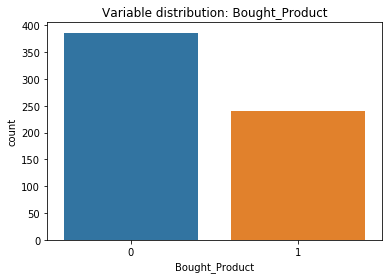

In [684]:
plot_col(X_train.Bought_Product,'Bought_Product')

Rozkład zmiennej celu jest delikatnie niezbalansowany, aczkolwiek różnica między obiema wartościami nie jest duża.

## Zmienne ciągłe

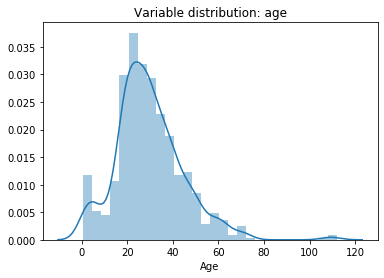

In [685]:
plot_var(X_train.Age,'age')

Rozkład wieku jest lekko skośny, przeważają młodzi klienci.

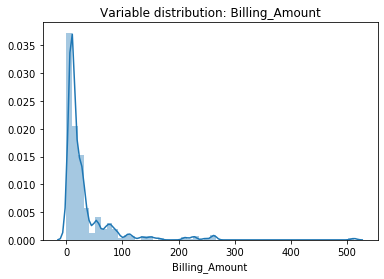

In [686]:
plot_var(X_train.Billing_Amount,'Billing_Amount')

Rozkład tej kolumny jest bardzo skośny, z większością wartości równą 0. Być może dobrze będzie przetransformować ją, tak aby ta kolumna była mniej skośna.

## Zmienne dyskretne

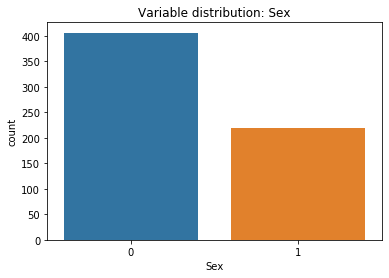

In [687]:
plot_col(X_train.Sex,'Sex')

Jest delikatna przewaga mężczyzn.

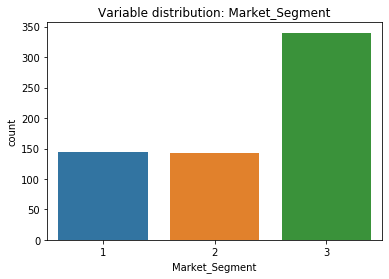

In [688]:
plot_col(X_train.Market_Segment,'Market_Segment')

Znacząco przeważają klienci należący do 3 segementu.

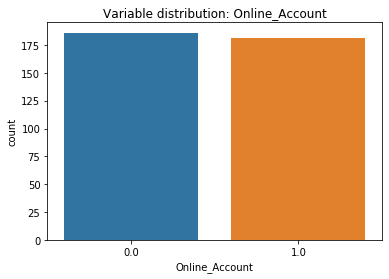

In [689]:
plot_col(X_train.Online_Account, 'Online_Account')

Rozkład posiadania konta online jest praktycznie idealnie pół na pół.

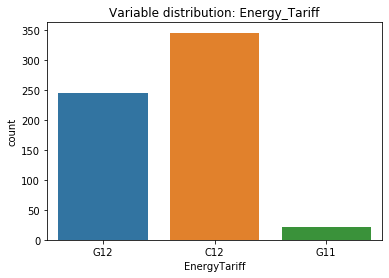

In [690]:
plot_col(X_train.EnergyTariff,'Energy_Tariff')

Mamy obecne 3 wartości w tej kolumnie, przy czym wartości 'G11' stanowią znikomy procent całości

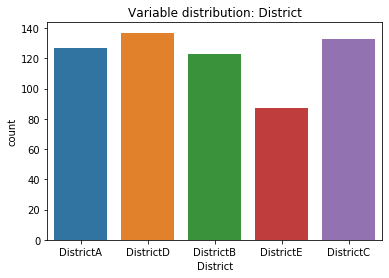

In [691]:
plot_col(X_train.District,'District')

Mamy do czynienia z 5 różnymi dystryktami, ich rozkład jest umiarkowanie równomierny.

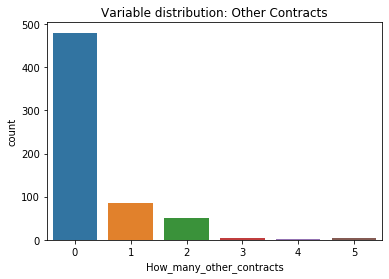

In [692]:
plot_col(X_train.How_many_other_contracts,'Other Contracts')

Rozkład kolumny innych kontraktów jest mocno nierównomierny, przeważają klienci bez dodatkowych kontraktów.

# Wpływ poszczególnych zmiennych na zmienną celu

Z racji na sporą ilość kolumn dyskretnych łatwo będzie spojrzeć na to jak rozkładają się poszczególne grupy w danych kolumnach względem naszej zmiennej celu.

In [693]:
def plot_targ(col, var):
    plot = sns.countplot(col,hue=X_train.Bought_Product)
    plot.set_title("Variable distribution: " + var)


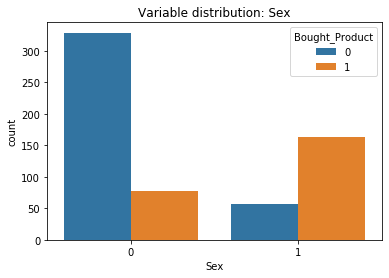

In [694]:
plot_targ(X_train.Sex,'Sex')

Widać bardzo dużą zależność pomiędzy tym czy produkt został kupiony, a płcią.

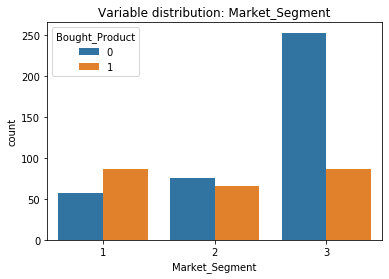

In [695]:
plot_targ(X_train.Market_Segment,'Market_Segment')

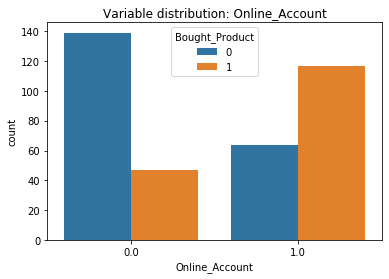

In [696]:
plot_targ(X_train.Online_Account, 'Online_Account')

Widać tutaj bardzo ciekawą zależnośc, a mianowicie klienci z kontem online są dużo bardziej chętni do kupowania produktów, niż ci któ©zy go nie mają.

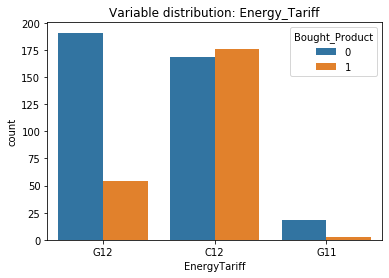

In [697]:
plot_targ(X_train.EnergyTariff,'Energy_Tariff')

Ten typ wykresu juz pozwala zaobserwować ciekawą zależność, a mianowicie klienci z grupą energii G12 są dużo mniej chętni do kupna produktu, niż ci z grupy C12.

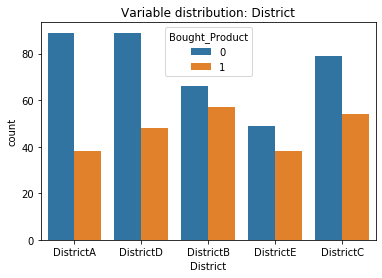

In [698]:
plot_targ(X_train.District,'District')

Analizując wizualnie ten wykres, to DystryktB oraz DystryktE wyróżniają się dość dużym procentem ludzi którzy kupili produkt.

## Zależności między danymi numerycznymi

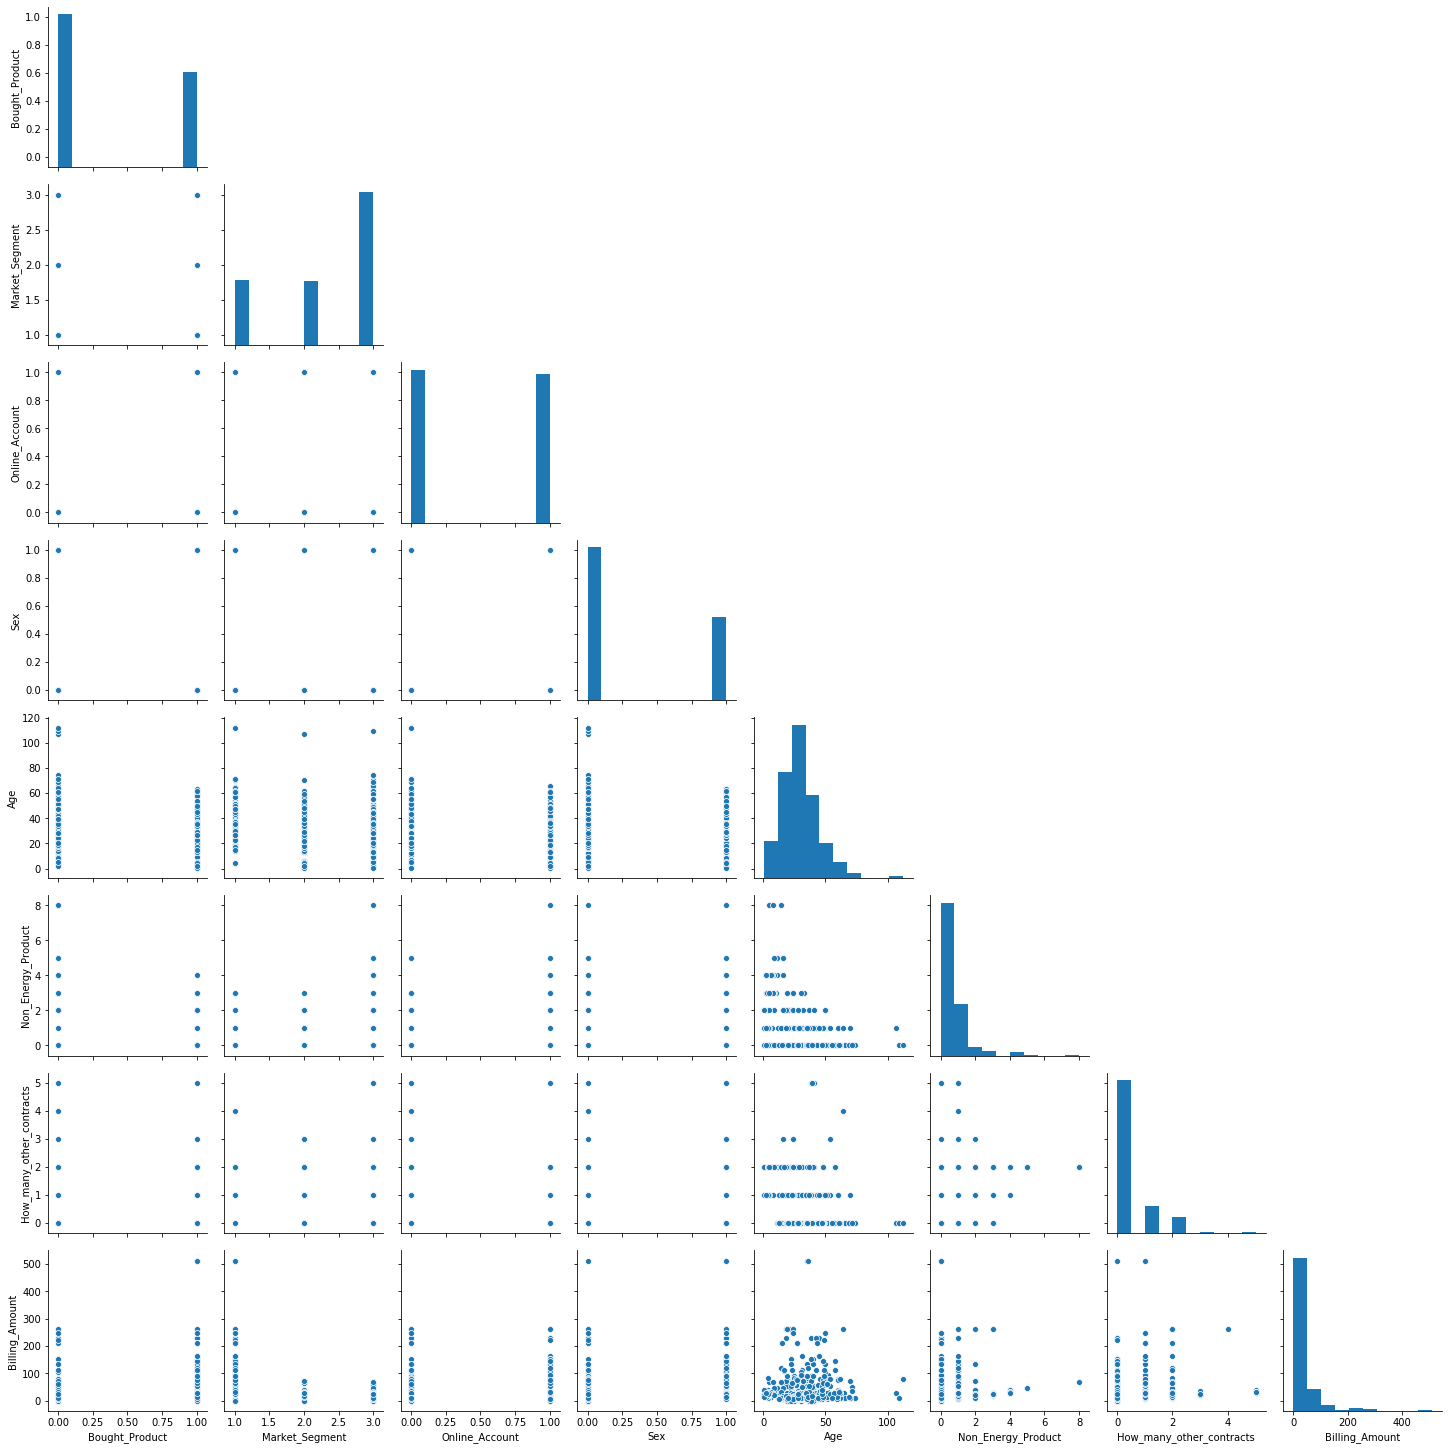

In [699]:
# Separate both dataframes into 
numeric_df = X_train.select_dtypes(exclude="object")
# categorical_df = df.select_dtypes(include="object")

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
g = sns.pairplot(numeric_df)
g.map_upper(hide_current_axis)

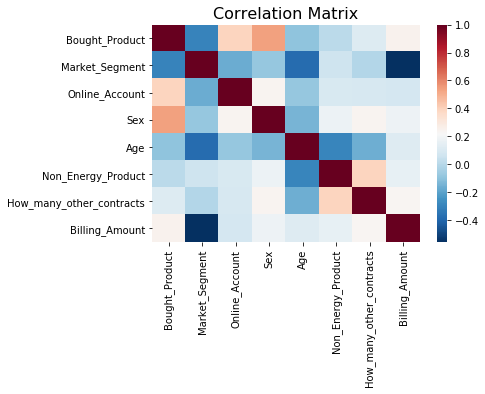

In [700]:
cor_df = numeric_df.copy()
#-1 means no contact before, calculating correlation with this variable it means NA
corr_numeric = cor_df.corr()


sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

Widać spore skorelowanie między zmienną celu, a płcią, co sugeruje że ta zmienna ma bardzo dużą moc predykcyjną. Dosć mocno skorelowana ze zmienną celu jest również zmienna Market Segment. 

## Wnioski

Większość kolumn ma dość prosty rozkład, kolumny dyskretne mają niewiele możliwych wartości. Sama zmienna celu jest delikatnie niezbalansowana. Mamy tylko 2 zmienne ciągłe: Age oraz BillingAmount, przy czym druga z nich jest mocno skośna. Odnośnie mocy predykcyjnej naszych kolumn, to interesujące wydają się kolumny: 
- Sex
- MarketSegment
- OnlineAccount

Z procesu EDA można sprobówać wyciągać wnioski, iż fakt bycia kobietą oraz posiadanie konta online znacząco zwiększa szanse na to, iż klient dokona zakupu. Z drugiej strony fakt bycia w 3 grupie MarketSegment znacząco te szanse zmniejsza.
Sprawdzimy w trakcie procesu modelowania czy moje przypuszczenia są prawdziwe. Jeśli chodzi o brakujące dane to  występują głownie w kolumnie OnlineAccount.

# Feature engineering

Przed przystąpieniem do modelowania, należy odpowiednio przetransformować zbiór danych, tak aby algorytmy uczenia maszynowego były w stanie z nim pracować.

## Data imputing

Na samym początku należy pozbyć się danych brakujących w obu zbiorach. Z etapu EDA wiemy iż głowne braki występuja w kolumnie Online Acount. Jednocześnie EDA ukazała iż ta kolumna zawiera dużo informacji na temat zmiennej celu. Dlatego moim zdaniem najlepszym rozwiązaniem tego problemu będzie utworzenie 3 kategorii 'NoData' która będzie informowała o braku danych w tej kolumnie.

In [701]:
X_train['Online_Account'].fillna('NoData',inplace=True)
X_test['Online_Account'].fillna('NoData',inplace=True)

Sprawdźmy czy dalej ta kolumna posiada dużą moc predykcyjną.

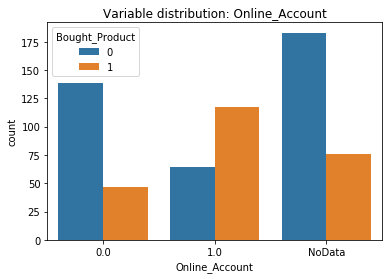

In [702]:
plot_targ(X_train.Online_Account, 'Online_Account')

W dalszym ciągu wygląda to interesująco.

Pozostałe braki danych są marginalne, w każdej z kolumn jest ich stosunkowo mało, więc bez większych przeszkód mogę posłużyć się prostym algorytmem uzupełniania braków danych jakim bedzie najczęsciej wysteępująca wartość w kolumnie dla danych dyskretnych oraz średnia arytmetyczna dla danych ciągłych. 

In [703]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Bought_Product            626 non-null    int64  
 1   Market_Segment            626 non-null    int64  
 2   Online_Account            626 non-null    object 
 3   EnergyTariff              611 non-null    object 
 4   Sex                       626 non-null    int64  
 5   Age                       616 non-null    float64
 6   Non_Energy_Product        626 non-null    int64  
 7   How_many_other_contracts  626 non-null    int64  
 8   Billing_Amount            618 non-null    float64
 9   District                  607 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 49.0+ KB


In [704]:
X_train['EnergyTariff'].fillna(X_train['EnergyTariff'].mode()[0],inplace=True)
X_test['EnergyTariff'].fillna(X_train['EnergyTariff'].mode()[0],inplace=True)

X_train['Age'].fillna(X_train['Age'].mean(),inplace=True)
X_test['Age'].fillna(X_train['Age'].mean(),inplace=True)

X_train['Billing_Amount'].fillna(X_train['Billing_Amount'].mean(),inplace=True)
X_test['Billing_Amount'].fillna(X_train['Billing_Amount'].mean(),inplace=True)

X_train['District'].fillna(X_train['District'].mode()[0],inplace=True)
X_test['District'].fillna(X_train['District'].mode()[0],inplace=True)

Wartości w zbiorze testowym uzupełniam statystykami ze zbioru treningowego, tak aby uniknąć wycieku danych.

In [705]:
X_test.isnull().sum().sum() + X_train.isnull().sum().sum() 

0

Jak widać imputacja się powiodła.

## Skośność

Jak wykazała EDA kolumna BillingAmount ma dość mocno skośny rozkład. Przed przystąpieniem do pracy z nią, dobrym pomysłem będzie zmniejszenie tego parametru.

In [706]:
skew(X_train.Billing_Amount)

4.449398894501554

In [707]:
X_train.Billing_Amount = np.log1p(X_train.Billing_Amount)
X_test.Billing_Amount = np.log1p(X_test.Billing_Amount)
skew(X_train.Billing_Amount)

0.3476724645999522

Zwykłe zlogarytmizowanie danych pomogło znacząco zmniejszyć skośność.

## Encoding

Jako encodera użyję TargetEncodera. Działa on wykorzystując dostępne informacje o zmiennej celu, tak aby jak najlepiej zmieniać dane kategoryczne na numeryczne.

In [708]:
X_train.drop(['Bought_Product'],inplace=True,axis=1) #Pozbywam się zmiennej celu z danych treningowych
encoder = TargetEncoder()
X_train = encoder.fit_transform(X_train,y_train)
X_test = encoder.transform(X_test)
cols = X_train.columns

In [709]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Market_Segment            626 non-null    int64  
 1   Online_Account            626 non-null    float64
 2   EnergyTariff              626 non-null    float64
 3   Sex                       626 non-null    int64  
 4   Age                       626 non-null    float64
 5   Non_Energy_Product        626 non-null    int64  
 6   How_many_other_contracts  626 non-null    int64  
 7   Billing_Amount            626 non-null    float64
 8   District                  626 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 44.1 KB


In [710]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Market_Segment            261 non-null    int64  
 1   Online_Account            261 non-null    float64
 2   EnergyTariff              261 non-null    float64
 3   Sex                       261 non-null    int64  
 4   Age                       261 non-null    float64
 5   Non_Energy_Product        261 non-null    int64  
 6   How_many_other_contracts  261 non-null    int64  
 7   Billing_Amount            261 non-null    float64
 8   District                  261 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 18.5 KB


Jak widać mamy już tylko dane numeryczne oraz nie mamy żadnych braków.

## Skalowanie

Dla niektórych algorytmów ważne jest, aby dane im dostarczone były przeskalowane. Do tego zadania dobrze sprawdzi się StandardScaler.

In [711]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelowanie

Finalnie po wszystkich przekstałeniach możemy przystąpić do modelowania danych.

Do modelowania użyję 3 algorytmów uczenia maszynowego:
- Regresja logistyczna
- Xgboost
- SVM

Użyję kroswalidacji, aby sprawdzić ich działanie, a dla najlepiej sprawującego się algorytmu dobiorę parametry poprzez BayesianOptimization. Jako miary będę używał accuracy, precision, recall oraz ROC AUC, ze szczególnym naciskiem na ostatnią miarę, jako dobrze sprawującą się w kontekście klasyfikacji binarnej.

## Regresja logistyczna

In [725]:
scoring = {'precision': 'precision_macro',
           'recall': 'recall_macro',
           'accuracy': 'accuracy',
           'auc': 'roc_auc'}

#Logistic regression
kfold = KFold(n_splits=3, random_state=42, shuffle=True)
logistic =  LogisticRegression(random_state=42)
r_log = cross_validate(logistic,X_train,y_train,scoring=scoring, cv=kfold)
vals = list(map(lambda x: np.mean(r_log[x]), r_log))
log = pd.DataFrame(vals,index = r_log.keys())
log.columns  = ['Wyniki']
log

,Wyniki
fit_time,0.009101
score_time,0.006522
test_precision,0.788115
test_recall,0.773166
test_accuracy,0.795554
test_auc,0.871435


## XGboost

In [713]:
xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4)
r_xgb = cross_validate(xg, X_train, y_train, cv=kfold, scoring=scoring)
vals = list(map(lambda x: np.mean(r_xgb[x]), r_xgb))
xgd = pd.DataFrame(vals,index = r_xgb.keys())
xgd.columns  = ['Wyniki']
xgd

,Wyniki
fit_time,0.053462
score_time,0.009023
test_precision,0.834586
test_recall,0.812870
test_accuracy,0.835480
test_auc,0.889287


## SVM

In [714]:
svm = SVC()
r_svm = cross_validate(svm, X_train, y_train, cv=kfold, scoring=scoring)
vals = list(map(lambda x: np.mean(r_svm[x]), r_svm))
sv = pd.DataFrame(vals,index = r_svm.keys())
sv.columns  = ['Wyniki']
sv

,Wyniki
fit_time,0.008763
score_time,0.010991
test_precision,0.830380
test_recall,0.797212
test_accuracy,0.825911
test_auc,0.873688


Analizując wyniki osiągane przez poszczegółne algorytmy widać, iż są one dośc podobne do siebie, jednakże minimalnie najlepsze osiąga XGboost. Wyniki są dobre, jednkaże nie są idealne. Jako przyczynę tego uważam mały rozmiar zbioru, przez co ciężko o to aby te algorytmy mogły rozwinąć skrzydła.

## Feature importance

Ciekawą rzeczą jaką można wyciągnąć z algorytmów drzewiastych jest feature importance. Jest to ważność cech wedle których algorytm dokonywał podziału danych w trakcie modelowania. Możemy dzięki temu okreslić moc predykcyjną kolumn, a więc porownać zaobserwowane dane z wnioskami poczynionymi w etapie EDA.`

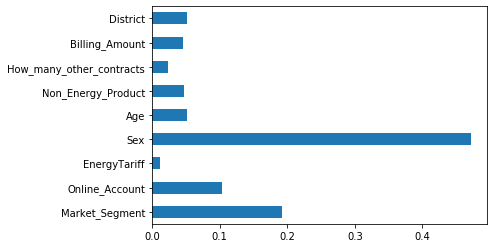

In [715]:
xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4)
xg.fit(X_train,y_train)
feat_importances = pd.Series(xg.feature_importances_, index=cols)
feat_importances.plot(kind='barh')

Feature Importance potwierdza to co udało mi się zaobserwować w procesie EDA, przy czym dla algorytmu Xgboost płeć osoby miała absolutnie kluczowe znaczenie w decydowaniu czy dokona ona zakupu

## Dobór parametrów

In [716]:
pbounds = {'learning_rate': (0.01, 1.0), 'n_estimators': (100.0, 1000.0), 'max_depth': (4.0,10.0), 
           'subsample': (0.5, 1.0), 'colsample_bytree': (0.5, 1.0),'gamma': (0.0,5.0)}

def xgboost_hyper_param(learning_rate,n_estimators,max_depth,subsample,colsample_bytree,gamma):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    clf = xgb.XGBClassifier(max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,
                            subsample=subsample,colsample_bytree=colsample_bytree,gamma=gamma)
    return np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc'))

optimizer = BayesianOptimization(f=xgboost_hyper_param, pbounds=pbounds, random_state=1)
optimizer.maximize()
print('Final Results')
print(optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.8691   |  0.7085   |  3.602    |  0.01011  |  5.814    |  232.1    |  0.5462   |
|  2        |  0.8746   |  0.5931   |  1.728    |  0.4028   |  7.233    |  477.3    |  0.8426   |
|  3        |  0.8787   |  0.6022   |  4.391    |  0.03711  |  8.023    |  475.6    |  0.7793   |
|  4        |  0.8547   |  0.5702   |  0.9905   |  0.8027   |  9.81     |  382.1    |  0.8462   |
|  5        |  0.8803   |  0.9382   |  4.473    |  0.09419  |  4.234    |  252.8    |  0.9391   |
|  6        |  0.8702   |  0.535    |  5.0      |  0.01     |  4.0      |  1e+03    |  0.6262   |
|  7        |  0.8618   |  0.5007   |  4.918    |  0.6546   |  4.605    |  779.8    |  0.882    |
|  8        |  0.8645   |  0.6089   |  4.914    |  0.5066   |  4.263    |  625.6    |  0.555    |
|  9        |  0.882

Proces optymalizacji bayesowskiej pozwolił wyznaczyć optymalne parametry w sposob duzo prostszy i bardziej efektywny niz chociazby GridSearch.

Sprawdźmy sprawowanie się modelu na wyznaczonych przez optymalizację parametrach.

In [726]:
xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=optimizer.max)
r_xgb = cross_validate(xg, X_train, y_train, cv=kfold, scoring=scoring)
vals = list(map(lambda x: np.mean(r_xgb[x]), r_xgb))
xgd = pd.DataFrame(vals,index = r_xgb.keys())
xgd.columns  = ['Wyniki']
xgd

,Wyniki
fit_time,0.089421
score_time,0.008295
test_precision,0.834586
test_recall,0.812870
test_accuracy,0.835480
test_auc,0.889287


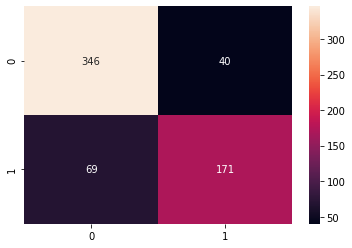

In [741]:
y_pred = cross_val_predict(xg,X_train, y_train, cv=3)
conf_mat = confusion_matrix(y_train, y_pred)
sns.heatmap(conf_mat, annot=True,fmt='g')

Ostateczne wyniki są umiarkowanie dobre i mogą posłużyć do skutecznej indentyfikacji klientów.

Warto zauważyć iż dużo bardziej jest dla nasz kosztowny błąd, gdy odrzucamy kogoś kto jest zainteresowany kupnem, niż gdy przyjmujemy kogoś kto nie jest nim zainteresowany. Dlatego dobrym pomysłem wydaję się być odpowiednie dostosowanie thresholdu, aby lepiej pozycjonować klientów.

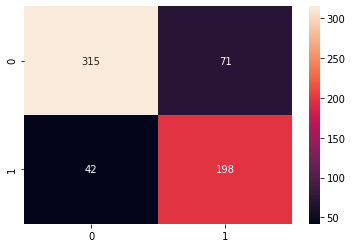

In [754]:
y_pred = cross_val_predict(xg,X_train, y_train, cv=3,method='predict_proba')
y_pred = y_pred[:,1]
for i in range(len(y_pred)):
    if y_pred[i]>0.3:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
conf_mat = confusion_matrix(y_train, y_pred)
sns.heatmap(conf_mat, annot=True,fmt='g')

# Ostateczna predykcja

In [723]:
xg.fit(X_train,y_train)
pred = xg.predict(X_test)
output = pd.DataFrame(pred,index=X_test_id)
output.columns = ['Predykcja']
output

,Predykcja
Id,
1,1
2,0
3,1
4,1
5,0
...,...
257,0
258,0
259,0


# Podsumowanie

Uważam iż udało mi się efektywnie przeanalizować dane oraz zbudować model zdolny do dobrego przewidywania tego czy klient będzie zainteresowany kupnem produktu. Obserwacje, które poczyniłem w trakcie EDA, tzn. fakt iż płeć oraz MarketSegment mają duży wpływ na zachowanie klienta okazały się prawdziwe. XGboost okazał się najlepszym z modeli, które przetestowałem, jego wyniki były satysfakcjonujące, tj. wartość AUC sięgała 0.89, co jest dobrym wynikiem. Z pewnością wyniki poprawiłoby zgromadzenie większej ilości danych, jako że 887 wierszy łącznie w zbiorze testowym oraz treningowym to dość mało. Dodatkowo z pewnością sporym usprawnieniem byłoby zebranie dodatkowych danych o klientach, co pozwoliłoby jeszcze lepiej przewidywać ich zachowania.